In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# One Layer GNN Metrics

For the model created in the last script, get predictions and metrics / performance information. 

Implementation notes:
  * To visualize the keras model, I had to "conda install" pydot and graphviz in my virtual environment. 
  * Model is saved/loaded in tensorflow format.  This is to workaround an issue with Keras format, https://github.com/tensorflow/tensorflow/issues/46659

*This script takes about 30 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np

In [3]:
from pathlib import Path
import importlib, pickle
from contextlib import redirect_stdout
from scikitplot.metrics import plot_lift_curve
import matplotlib.pyplot as plt

In [4]:
from stellargraph import StellarGraph
import stellargraph as sg
import keras
from stellargraph.layer import HinSAGE, MeanHinAggregator
from stellargraph.mapper import HinSAGENodeGenerator

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import tensorflow.keras.metrics as km
from keras.utils import plot_model
from keras import initializers
import tensorflow as tf

2024-01-18 06:30:49.167240: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-18 06:30:49.167265: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-18 06:30:49.167270: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-18 06:30:49.167308: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-18 06:30:49.167326: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
from sba_gnn.sba_gnn import sg_gnn, sg_plot 

## Import Data

##### Stellargraphs - all nodes

In [6]:
with open(Path(setup.temp_path).joinpath('20_DATA_stellargraph_all.pkl'), 'rb') as fin:
      sba_all  = pickle.load(fin)

In [7]:
label_data = pd.read_parquet(Path(setup.temp_path).joinpath('20_DATA_label_info.parquet')).sort_index()

##### Model

In [8]:
model = keras.models.load_model(Path(setup.temp_path).joinpath('21_DATA_model.keras'),
                               safe_mode=False,
                               custom_objects={'MeanHinAggregator':MeanHinAggregator})

/Users/valeriecarey/miniconda3/envs/tf_p38/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


## Model Info
Print and save some information about the model layers (summary and plot)

In [9]:
with open(Path(setup.temp_path).joinpath('22_REPORT_model_summary.txt'), "w") as f:
    with redirect_stdout(f):
        print(model.summary())
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 10, 10)]             0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 10, 10)]             0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 1, 10)]              0         []                            
                                                                                                  
 reshape (Reshape)           (None, 1, 10, 10)            0         ['input_2[0][0]']             
                                                                                              

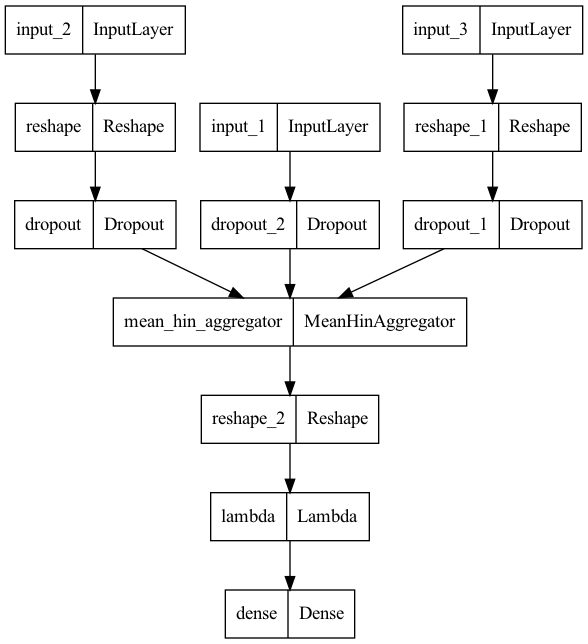

In [10]:
plot_model(model, Path(setup.temp_path).joinpath('22_model_plot_simp.png'))

The 2-hop model has three MeanHinAggregator layers, likely reflecting the 2 edge types.

In [11]:
%%capture
plot_model(model, to_file=Path(setup.temp_path).joinpath('22_model_plot_with_shapes.png'),
          show_shapes=True)

## Graph Containing All Nodes
Get predictions amd metrics

##### Get generator and predict for all nodes (train, validation, test)

In [12]:
generator = HinSAGENodeGenerator(sba_all, batch_size=setup.gnn_batch_size, 
                                 num_samples=[setup.gnn_num_samples[0]],
                                 head_node_type='LoanNr_ChkDgt',
                                 seed=2454)

In [13]:
all_flow = generator.flow(label_data.index, label_data['target'], shuffle=False)

In [14]:
tf.random.set_seed(16)
keras.utils.set_random_seed(812)
sg.random.set_seed(4345)

In [15]:
all_predictions = model.predict(all_flow)

   42/21503 [..............................] - ETA: 53s 

2024-01-18 06:32:42.407995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21503/21503 [==============================] - 52s 2ms/step


In [16]:
all_predictions.shape

(688081, 1)

In [17]:
pd.Series(all_predictions[:,0], index=label_data.index)

LoanNr_ChkDgt
1000014003    0.079566
1000024006    0.085499
1000034009    0.027282
1000084002    0.032023
1000094005    0.060693
                ...   
9995473009    0.041915
9995493004    0.032857
9995573004    0.080678
9995603000    0.072929
9995613003    0.031063
Length: 688081, dtype: float32

In [18]:
all_pred_df = pd.concat([pd.Series(all_predictions[:,0], index=label_data.index).rename('predict_prob'),
                         label_data], axis=1) \
    .reset_index()

In [19]:
all_pred_df.head(3)

,LoanNr_ChkDgt,predict_prob,dset,dset_naics_holdout,target
0,1000014003,0.079566,train,0,0
1,1000024006,0.085499,test,0,0
2,1000034009,0.027282,train,0,0


## Threshold Tune & Binary Predictions
Using training probability predictions

In [20]:
all_pred_train = all_pred_df[all_pred_df['dset'] == 'train']

In [21]:
thresh_tune_data = sg_plot.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [22]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
10,0.20,0.422547
9,0.18,0.419220
11,0.22,0.419007


In [23]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.2

##### Append binary predictions to probability predictions

In [24]:
importlib.reload(sg_plot)

<module 'sba_gnn.sba_gnn.sg_plot' from '/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code/sba_gnn/sba_gnn/sg_plot.py'>

In [25]:
all_pred_df['predict_bin'] = sg_plot.get_binary_predictions(all_pred_df['predict_prob'], best_thresh)

In [26]:
all_pred_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
0    0.505975
1    0.494025
Name: proportion, dtype: float64

In [27]:
all_pred_df.to_parquet(Path(setup.temp_path).joinpath('22_DATA_predictions_all.parquet'))

In [28]:
all_pred_df.sample(3)

,LoanNr_ChkDgt,predict_prob,dset,dset_naics_holdout,target,predict_bin
442043,5627373001,0.034426,test,1,0,0
161069,2441396004,0.304905,train,0,1,1
3258,1028865009,0.298497,val,0,0,1


In [29]:
pd.crosstab(all_pred_df['predict_bin'], all_pred_df['target'])

target,0,1
predict_bin,,
0,310020,38132
1,238373,101556


## Metrics

In [39]:
metrics_dset_df = all_pred_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = all_pred_df[all_pred_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('22_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.604202,0.422795,0.298758,0.722943,0.329731,0.695266,NaN
1,train,0.596193,0.422547,0.297736,0.727527,0.330819,0.692518,NaN
2,val,0.598210,0.427386,0.302200,0.729635,0.333417,0.695114,NaN
0,test,0.598468,0.425878,0.300454,0.731055,0.333538,0.694436,0.0
1,test,0.621950,0.412426,0.293014,0.696111,0.316925,0.697104,1.0


## Lift

In [40]:
pred_test_df = all_pred_df[all_pred_df['dset'] == 'test']

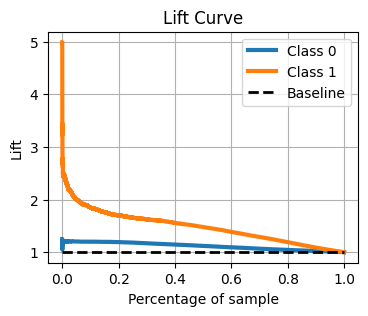

In [41]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('22_PLOT_lift_curve.png'),bbox_inches='tight')

In [42]:
# Create a new model object to access the embeddings 1 layers above (normalized output)
emb_model = Model(inputs=model.input, outputs=model.layers[-2].output)

In [43]:
embeddings = emb_model.predict(all_flow)

   21/21503 [..............................] - ETA: 1:52

2024-01-18 06:36:41.913309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21503/21503 [==============================] - 56s 3ms/step


In [44]:
embeddings_df = pd.DataFrame(embeddings, index=label_data.index)
embeddings_df.columns = [f'emb_{c:02d}' for c in embeddings_df.columns]

In [45]:
embeddings_df.describe()

,emb_00,emb_01,emb_02,emb_03,emb_04,emb_05,emb_06,emb_07,emb_08,emb_09,...,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63
count,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,...,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000
mean,0.026137,-0.090729,-0.083341,-0.159817,0.153316,-0.021168,0.096621,0.158736,-0.096513,-0.061793,...,-0.162152,-0.017584,0.054491,-0.116665,0.162559,-0.007934,-0.010584,0.030737,0.023110,-0.162333
std,0.075283,0.110581,0.089449,0.012892,0.028002,0.110110,0.031890,0.029135,0.052817,0.088821,...,0.007389,0.074781,0.045355,0.055419,0.007449,0.063347,0.055348,0.056552,0.065920,0.007435
min,-0.175718,-0.186931,-0.172300,-0.187337,-0.148643,-0.184330,-0.117644,-0.183089,-0.167456,-0.174824,...,-0.189949,-0.144727,-0.138778,-0.177434,0.137515,-0.155601,-0.148342,-0.139191,-0.161887,-0.190116
25%,-0.032745,-0.164088,-0.147856,-0.166371,0.152631,-0.099547,0.072585,0.155889,-0.130573,-0.140454,...,-0.167420,-0.080059,0.023905,-0.150775,0.157250,-0.058255,-0.052603,-0.012264,-0.029263,-0.167618
50%,0.029604,-0.156142,-0.126430,-0.160707,0.159797,-0.070484,0.100105,0.161516,-0.112360,-0.092543,...,-0.162236,-0.043346,0.057520,-0.139639,0.162645,-0.002025,-0.009145,0.032597,0.046657,-0.162419
75%,0.083852,-0.013387,-0.052078,-0.154636,0.165500,0.132338,0.124239,0.166932,-0.092445,0.011195,...,-0.156911,0.046155,0.088475,-0.107110,0.167843,0.044411,0.031386,0.075956,0.076851,-0.157055
max,0.167689,0.187629,0.169305,0.126587,0.187431,0.182761,0.165042,0.190136,0.127898,0.174378,...,-0.118197,0.166885,0.163361,0.150121,0.190176,0.135003,0.142452,0.168508,0.133988,-0.131125


In [46]:
embeddings_df.to_parquet(Path(setup.temp_path).joinpath('22_DATA_embeddings.parquet'))